In [ ]:
# Loadiing Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Adding Google Drive path
import sys
sys.path.append('/content/drive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiGyEbc9sKbsfeHMoFEdeSiopHmak3TxQhlz6QrzcJJ6zMd3bRR4cw


# Setup

In [ ]:
# Importing basic libraries
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import random
import time
import h5py
import ATSNet_Orignal
import ATSNet_woskipconnect
import ATSNet_wo


In [ ]:
class preprocessUtil:

  @staticmethod
  def batch_norm(arr):
    if np.max(arr)==1:
        return arr
    return arr/np.max(arr)
  
  @staticmethod
  def drawOnto(image, label):
    return preprocessUtil.batch_norm(image)+preprocessUtil.batch_norm(label)


In [ ]:
# Dataset Loader https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
from matplotlib import cm
np.random.seed(47)
import copy
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, index, X_path, transform_X, transform_y):
        """
            X_path: List of X_paths
            Transform: X Transforms
            index: fold number ; chooses the dataset to be trained on out of the 5
        """
        self.fold = 5
        self.index = index
        #5% dataset is left out for test 
        #the remaining dataset is split in 4:1 (5-fold cross validation) and 5 separate datasets are created 

        self.TRAIN_VALID_TEST = (80,20)
        self.X_path = X_path
        self.train_paths = [[] for i in range(self.fold)]
        self.valid_paths = [[] for i in range(self.fold)]
        self.test_paths = []

        tumor_paths = []
        x=0
        for path in X_path:
            paths = os.listdir(path)
            paths = [path+pth for pth in paths]
            tumor_paths.append(paths)
            test_length = 5*len(paths)//100
            self.test_paths.append(paths[-test_length:])
            del paths[-test_length:]
            tumor_paths[x] = paths
            x+=1
        
        for i in range(self.fold):
        
          for j in range(len(tumor_paths)):
            train_length = self.TRAIN_VALID_TEST[0]*len(tumor_paths[j])//100
            valid_length = self.TRAIN_VALID_TEST[1]*len(tumor_paths[j])//100
            paths = tumor_paths[j].copy()
            self.valid_paths[i].append(paths[(i)*valid_length:(i+1)*valid_length])
            del paths[(i)*valid_length:(i+1)*valid_length]
            self.train_paths[i].extend(paths)

          print('Fold',i)
          print("Training Set",len(self.train_paths[i]))
          print("3 validation set for each tumor")
          print([len(self.valid_paths[i][j]) for j in range(len(self.valid_paths[i]))])
          print('---------------------')

        print("Test set---",[len(self.test_paths[i])for i in range(len(self.test_paths))])          
      
        """
        temp code---not  efficient
        
        # for i in range(self.fold):
        #   for path in X_path:
        #     paths = os.listdir(path)
        #     paths = [path+pth for pth in paths]
        #     test_length = 5*len(paths)//100
        #     if x<3:
        #       #3 different paths(tumors). Its only repetition after that
        #       self.test_paths.append(paths[-test_length:])
        #       x+=1
        #     del paths[-test_length:]
        #     train_length = self.TRAIN_VALID_TEST[0]*len(paths)//100
        #     valid_length = self.TRAIN_VALID_TEST[1]*len(paths)//100
        #     self.valid_paths[i].append(paths[(i)*valid_length:(i+1)*valid_length])
        #     del paths[(i)*valid_length:(i+1)*valid_length]
        #     self.train_paths[i].extend(paths)
        #   print('Fold',i)
        #   print("Training Set",len(self.train_paths[i]))
        #   print("3 validation set for each tumor")
        #   print([len(self.valid_paths[i][j]) for j in range(len(self.valid_paths[i]))])
        #   print('---------------------')
        # print("Test set---",[len(self.test_paths[i])for i in range(len(self.test_paths))])          

        """

        self.transform_X = transform_X
        self.transform_y = transform_y
        self.TRAIN_LENGTHS = len(self.train_paths[0])
        self.VALID_LENGTHS = [len(path) for path in self.valid_paths[self.index]]
        self.TEST_LENGTHS = [len(path) for path in self.test_paths]

    def __len__(self):
        return (self.TRAIN_LENGTHS)

    def __getitem__(self, idx):
      dic = {}
      with h5py.File(self.train_paths[self.index][idx], 'r') as f:
        f = f["cjdata"]
        for k, v in f.items():
          dic[k] = np.array(v)
          
        if dic["image"].shape != (512,512):
            img = Image.fromarray(dic["image"], 'L')
            img = img.resize((512,512))
            dic["image"] = np.array(img)
            img = Image.fromarray(dic["label"], 'L')
            img = img.resize((512,512))
            dic["label"] = np.array(img)
            img = Image.fromarray(dic["tumorMask"], 'L')
            img = img.resize((512,512))
            dic["tumorMask"] = np.array(img)
        sample = {'image': preprocessUtil.batch_norm(dic["image"]), 'labels': preprocessUtil.batch_norm(dic["tumorMask"]), 'id': dic["label"]}
        return sample

    def valid_item(self, id, idx):
      dic = {}
      with h5py.File(self.valid_paths[self.index][id][idx], 'r') as f:
        f = f["cjdata"]
        for k, v in f.items():
          dic[k] = np.array(v)
        if dic["image"].shape != (512,512):
            img = Image.fromarray(dic["image"], 'L')
            img = img.resize((512,512))
            dic["image"] = np.array(img)
            img = Image.fromarray(dic["label"], 'L')
            img = img.resize((512,512))
            dic["label"] = np.array(img)
            img = Image.fromarray(dic["tumorMask"], 'L')
            img = img.resize((512,512))
            dic["tumorMask"] = np.array(img)


        sample = {'image': preprocessUtil.batch_norm(dic["image"]), 'labels': preprocessUtil.batch_norm(dic["tumorMask"]), 'id': dic["label"]}
        return sample

    def test_item(self, id, idx):
      dic = {}
      with h5py.File(self.test_paths[id][idx], 'r') as f:
        f = f["cjdata"]
        for k, v in f.items():
          dic[k] = np.array(v)
        if dic["image"].shape != (512,512):
            img = Image.fromarray(dic["image"], 'L')
            img = img.resize((512,512))
            dic["image"] = np.array(img)
            img = Image.fromarray(dic["label"], 'L')
            img = img.resize((512,512))
            dic["label"] = np.array(img)
            img = Image.fromarray(dic["tumorMask"], 'L')
            img = img.resize((512,512))
            dic["tumorMask"] = np.array(img)


        sample = {'image': preprocessUtil.batch_norm(dic["image"]), 'labels': preprocessUtil.batch_norm(dic["tumorMask"]), 'id': dic["label"]}
        return sample

In [ ]:
X_path = ['/content/drive/My Drive/Brain_Dataset/linki/1/', '/content/drive/My Drive/Brain_Dataset/linki/2/', '/content/drive/My Drive/Brain_Dataset/linki/3/']

# Transforms https://pytorch.org/docs/stable/torchvision/transforms.html
transform_X = transforms.Compose([
     transforms.ToTensor()])

transform_y = transforms.Compose([
     transforms.ToTensor()])

BrainTrainSet = BrainTumorDataset(3,X_path, transform_X, transform_y)

# NOTE: Keeping batch_size = 2 due to colab RAM limit
BrainTrainLoader = torch.utils.data.DataLoader(BrainTrainSet,batch_size=2,shuffle=True, num_workers=8)

Fold 0
Training Set 2331
3 validation set for each tumor
[134, 271, 176]
---------------------
Fold 1
Training Set 2331
3 validation set for each tumor
[134, 271, 176]
---------------------
Fold 2
Training Set 2331
3 validation set for each tumor
[134, 271, 176]
---------------------
Fold 3
Training Set 2331
3 validation set for each tumor
[134, 271, 176]
---------------------
Fold 4
Training Set 2331
3 validation set for each tumor
[134, 271, 176]
---------------------
Test set--- [35, 71, 46]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
np.array(BrainTrainSet[2149]["labels"]).shape

(512, 512)

In [ ]:
BrainTrainSet.__len__()

2331

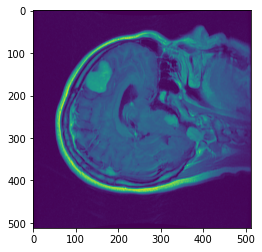

In [ ]:
dic = BrainTrainSet.test_item(0,2)
plt.imshow(dic["image"])

# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ATSNet_Orignal.link_net(1).to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(1, 128, 128))

In [ ]:
import torch
import torch.optim as optim

class dice_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(pred, target, epsilon=1e-7, use_sigmoid=True):
      pred = pred.contiguous()
      if use_sigmoid:
          pred = torch.sigmoid(pred)
      target = target.contiguous()
      intersection = (pred * target).sum(dim=2).sum(dim=2)
      loss = (1 - ((2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)))
      return loss.mean()

criterion = dice_loss().to(device) #### nn.MSELoss().to(device)#RMSLELoss().cuda()
# criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0085,betas=(0.99, 0.9999999))  #### optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.98)


In [ ]:

model.load_state_dict(torch.load('/content/drive/My Drive/brainnet_batch_2.pth'))
def train(epoch):
    model.train()
    tr_loss = 0
    #losses_list = []
    # getting the training set
    start = time.time()

    for i, data in enumerate(BrainTrainSet, 0):
        # get the inputs; data is a list of [inputs, labels]

        x_train, y_train = torch.Tensor(data["image"].reshape((1,1,512,512))).to(device), torch.Tensor(data["labels"]).to(device)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        # prediction for training and validation set
        output_train = model(x_train.float())

        # computing the training and validation loss
        loss_train = dice_loss.forward(output_train, y_train.reshape((1,1,512,512)))
        #train_losses.append(loss_train)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        tr_loss += loss_train.item()
        # losses_list.append(loss_train.item())
            # printing the validation loss
        # print('Epoch : ',epoch+1, 'Batch : ', i, ' Loss : ', tr_loss, 'Time : ', time.time()-start)
    torch.save(model.state_dict(), '/content/drive/My Drive/brainnet_batch_2.pth')
    print('Epoch : ',epoch+1, ' Loss : ', tr_loss,"Time: ",time.time()-start, "lr:",optimizer.param_groups[0]['lr'])
    return tr_loss
    return 1
# defining the number of epochs
n_epochs = 12
# empty list to store training losses
train_losses = [] 
# training the model
for epoch in range(n_epochs,26):
    scheduler.step()
    train_losses.append(train(epoch))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :  13  Loss :  774.7046881914139 Time:  1045.8579604625702 lr: 0.0085
Epoch :  14  Loss :  737.3676149845123 Time:  417.33917260169983 lr: 0.0085
Epoch :  15  Loss :  722.4121342301369 Time:  417.84353399276733 lr: 0.0085
Epoch :  16  Loss :  696.5351560115814 Time:  418.07535791397095 lr: 0.0085
Epoch :  17  Loss :  747.0867606401443 Time:  418.30195474624634 lr: 0.00833
Epoch :  18  Loss :  672.1844792366028 Time:  418.4555416107178 lr: 0.00833
Epoch :  19  Loss :  625.3299332261086 Time:  418.4429497718811 lr: 0.00833
Epoch :  20  Loss :  661.2906581759453 Time:  418.5330762863159 lr: 0.00833
Epoch :  21  Loss :  626.2381459474564 Time:  418.57281374931335 lr: 0.00833
Epoch :  22  Loss :  613.6741558909416 Time:  418.53327560424805 lr: 0.008163400000000001
Epoch :  23  Loss :  578.123865365982 Time:  418.3622033596039 lr: 0.008163400000000001
Epoch :  24  Loss :  546.9938864707947 Time:  418.6499924659729 lr: 0.008163400000000001
Epoch :  25  Loss :  537.505654335022 Time:  41

# Loading and Testing

In [ ]:

model.load_state_dict(torch.load('/content/drive/My Drive/attention_wo_join.pth'))
def train(epoch):
    model.train()
    tr_loss = 0
    #losses_list = []
    # getting the training set
    start = time.time()

    for i, data in enumerate(BrainTrainSet, 0):
        # get the inputs; data is a list of [inputs, labels]

        x_train, y_train = torch.Tensor(data["image"].reshape((1,1,512,512))).to(device), torch.Tensor(data["labels"]).to(device)

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        # prediction for training and validation set
        output_train = model(x_train.float())

        # computing the training and validation loss
        loss_train = dice_loss.forward(output_train, y_train.reshape((1,1,512,512)))
        #train_losses.append(loss_train)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        tr_loss += loss_train.item()
        # losses_list.append(loss_train.item())
            # printing the validation loss
        print('Epoch : ',epoch+1, 'Batch : ', i, ' Loss : ', tr_loss, 'Time : ', time.time()-start)
    torch.save(model.state_dict(), '/content/drive/My Drive/attention_wo_join.pth')
    print('Epoch : ',epoch+1, ' Loss : ', tr_loss,"Time: ",time.time()-start, "lr:",optimizer.param_groups[0]['lr'])
    return tr_loss
    return 1
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = [] 
# training the model
for epoch in range(n_epochs):
    scheduler.step()
    train_losses.append(train(epoch))

NameError: ignored

In [ ]:
model = models_2.link_net(in_ch=1).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/BRAINNET/brainnetz_5_fold.pth", map_location = device))

<All keys matched successfully>

In [ ]:
x = model(torch.Tensor(BrainTrainSet.test_item(0,2)["image"].reshape((1,1,512,512))).float().cuda())

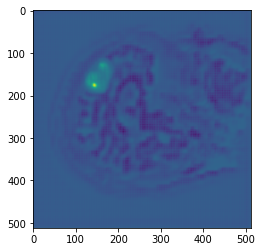

In [ ]:
plt.imshow(x.cpu().detach().numpy().reshape((512,512)))

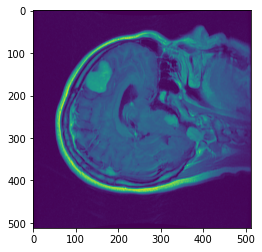

In [ ]:
dic = BrainTrainSet.test_item(0,2)
plt.imshow(dic["image"])


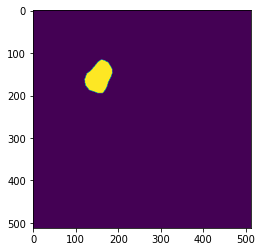

In [ ]:
plt.imshow(BrainTrainSet.test_item(0,2)["labels"].reshape((512,512)))

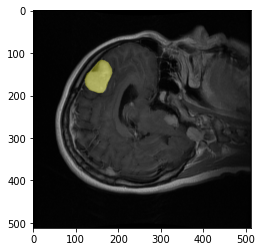

In [ ]:
img1 = BrainTrainSet.test_item(0,2)["image"].reshape((512,512))
img2 = BrainTrainSet.test_item(0,2)["labels"].reshape((512,512))
from skimage import segmentation
from skimage import color

result_image = color.label2rgb(img2, img1,kind='overlay',colors=['yellow'],bg_label=0)

plt.imshow(result_image)


In [ ]:
 y = x.cpu().detach().numpy().reshape((512,512))

In [ ]:
## THRESHOLDING
y[y > 0.1] = 1
y[y < 0.1] = 0

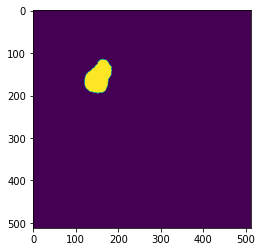

In [ ]:
plt.imshow(y)

In [ ]:
BrainTrainSet.TEST_LENGTHS

[35, 71, 46]

In [ ]:
#dice factor
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6, use_sigmoid = True):
    # make sure the tensors are align in memory and convert to probabilities if needed
    pred = pred.contiguous()
    if use_sigmoid:
        pred = torch.sigmoid(pred)
    target = target.contiguous()

    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)
    return dice.mean()

In [ ]:
# model = models_2.link_net(in_ch=1).to(device)
model = ATSNet_woskipconnect.link_net(1).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/brainnet_wo_skip.pth", map_location = device))
res = []
for i, paths in enumerate(BrainTrainSet.test_paths):
  s = 0
  for j in range(len(paths)):
      data = BrainTrainSet.test_item(i, j)
      x_test, y_test = torch.Tensor(data["image"].reshape((1,1,512,512))).to(device), torch.Tensor(data["labels"]).to(device)
      output_test = model(x_test.float())
      y_test = y_test.reshape((1,1,512,512))
      s+=dice_coeff(output_test, y_test)
  print(s)
  res.append(s)

val = sum(res)/sum(BrainTrainSet.TEST_LENGTHS)
print(val)

tensor(32.5783, device='cuda:0')
tensor(55.1470, device='cuda:0')
tensor(42.1874, device='cuda:0')
tensor(0.8547, device='cuda:0')


<Figure size 432x288 with 0 Axes>

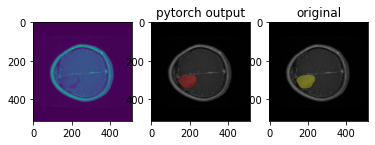

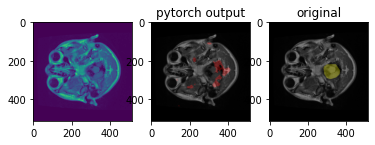

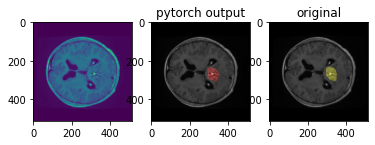

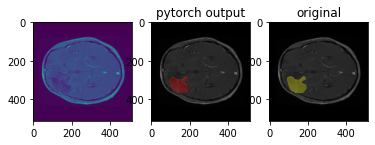

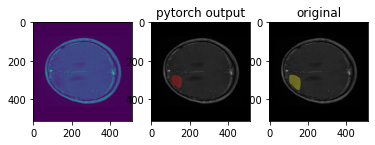

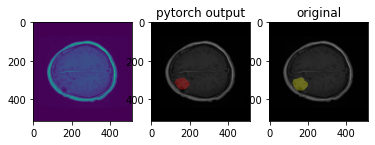

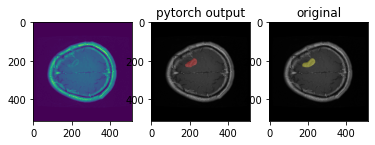

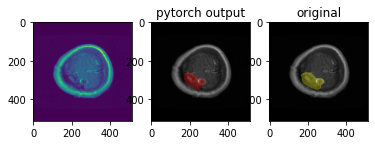

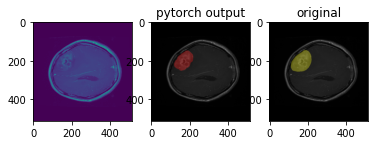

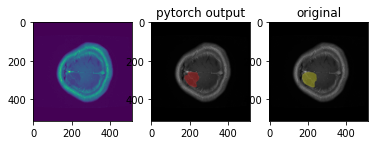

In [ ]:
from skimage import segmentation
from skimage import color

# model = models_2.link_net(in_ch=1).to(device)I
model.load_state_dict(torch.load("/content/drive/My Drive/brainnet_orignal_ver_2.pth", map_location = device))
for i in range(20,30):
  n = i
  tumor = 1
  x = model(torch.Tensor(BrainTrainSet.test_item(tumor,n)["image"].reshape((1,1,512,512))).float().cuda())
  y = x.cpu().detach().numpy().reshape((512,512))
  y[y > 0.1] = 1
  y[y < 0.1] = 0
  fig = plt.figure(n)
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
  ax1.imshow(BrainTrainSet.test_item(tumor,n)["image"])
  ax3.imshow(color.label2rgb(BrainTrainSet.test_item(tumor,n)["labels"], BrainTrainSet.test_item(tumor,n)["image"],kind='overlay',colors=['yellow','blue'],bg_label=0))
  ax3.set_title("original")
  y = color.label2rgb(y, BrainTrainSet.test_item(tumor,n)["image"],kind='overlay',colors=['red'],bg_label=0)
  ax2.imshow(y)
  ax2.set_title("pytorch output")


Pytorch Pruning

In [ ]:
import torch.nn.utils.prune as prune
count = 0
for name, module in model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.ln_unstructured(module, name='weight', amount=0.5)
        count+=1
    elif isinstance(module, torch.nn.ConvTranspose2d):
        prune.ln_unstructured(module, name='biaweights', amount=0.5)
        count+=1      

In [ ]:
res = []
for i, paths in enumerate(BrainTrainSet.valid_paths):
  s = 0
  for j in range(len(paths)):
      data = BrainTrainSet.valid_item(i, j)
      x_test, y_test = torch.Tensor(data["image"].reshape((1,1,512,512))).to(device), torch.Tensor(data["labels"]).to(device)
      output_test = model(x_test.float())
      y_test = y_test.reshape((1,1,512,512))
      s+=dice_coeff(output_test, y_test)
  print(s)
  res.append(s)

val = sum(res)/sum(BrainTrainSet.VALID_LENGTHS)

tensor(31.4067, device='cuda:0')
tensor(46.3866, device='cuda:0')
tensor(39.9258, device='cuda:0')


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/brainnet_pruned_v3.pth')

In [ ]:
print('Size (MB):', os.path.getsize("/content/drive/My Drive/BRAINNET/brainnet_f2.pth")/1e6)
print('Size (MB):', os.path.getsize("/content/drive/My Drive/brainnet_pruned_v3.pth")/1e6)

Size (MB): 191.668827
Size (MB): 382.904919


TENSORFLOW PRUNING


In [ ]:
import tensorflow as tf

In [ ]:

interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/BRAINNET/brainnet_5_fold.tflite")
interpreter.allocate_tensors()
val = 10


# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
inp = BrainTrainSet.test_item(0,val)["image"].reshape((1,1,512,512))

# Test the model on random input data.
input_data = np.array(inp, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
n = output_data.reshape((512,512))
m =  output_data.reshape((512,512)).copy()

x = model(torch.Tensor(BrainTrainSet.test_item(0,val)["image"].reshape((1,1,512,512))).float().cuda())
y = x.cpu().detach().numpy().reshape((512,512))



Text(0.5, 1.0, 'pytorch output')

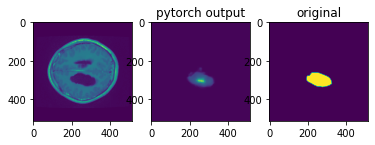

In [ ]:
tumor = 1
n = 37
x = model(torch.Tensor(BrainTrainSet.test_item(tumor,n)["image"].reshape((1,1,512,512))).float().cuda())
y = x.cpu().detach().numpy().reshape((512,512))

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(BrainTrainSet.test_item(tumor,n)["image"])
ax3.imshow(BrainTrainSet.test_item(tumor,n)["labels"])
ax3.set_title("original")
ax2.imshow(y)
ax2.set_title("pytorch output")



Text(0.5, 1.0, 'tflite output ')

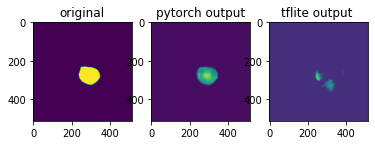

In [ ]:

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(BrainTrainSet[val]["labels"])
ax1.set_title("original")
ax2.imshow(y)
ax2.set_title("pytorch output")
ax3.imshow(n)
ax3.set_title("tflite output ")



In [ ]:
#dice factor
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6, use_sigmoid = True):
    # make sure the tensors are align in memory and convert to probabilities if needed
    pred = pred.contiguous()
    if use_sigmoid:
        pred = torch.sigmoid(pred)
    target = target.contiguous()

    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)
    return dice.mean()

In [ ]:

# Dice factoe tensorflow
from keras import backend as K
def dice_coeff(y_true,y_pred,smooth=1e-6):
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true*y_pred)
  dice= (2.*intersection+smooth)/(K.sum(y_true)+K.sum(y_pred)+smooth)

  return -dice




In [ ]:
res = []
for i, paths in enumerate(BrainTrainSet.valid_paths):
  s = 0
  for j in range(len(paths)):
      data = BrainTrainSet.valid_item(i, j)
      y_test = data["labels"].reshape((1,1,512,512))
      #y_test = torch.Tensor(data["labels"]).to(device)
      x_test = data["image"].reshape((1,1,512,512))
      input_data = np.array(x_test, dtype=np.float32)
      interpreter.set_tensor(input_details[0]['index'], input_data)
      interpreter.invoke()
      output_test = interpreter.get_tensor(output_details[0]['index'])
      y_test = y_test.reshape((1,1,512,512))
      #output_test= torch.Tensor(output_test).to(device)
      s+=dice_coeff( y_test.astype('float32'),output_test.astype('float32'))
  print(s)
  res.append(s)

val = sum(res)/sum(BrainTrainSet.VALID_LENGTHS)

tf.Tensor(27.543413, shape=(), dtype=float32)
tf.Tensor(1.0653418, shape=(), dtype=float32)
tf.Tensor(8.732881, shape=(), dtype=float32)


In [ ]:
print(val)

tensor(0.3892, device='cuda:0')


In [ ]:
BrainTrainSet.VALID_LENGTHS

[35, 71, 46]

In [ ]:
from pytorch2keras.converter import pytorch_to_keras


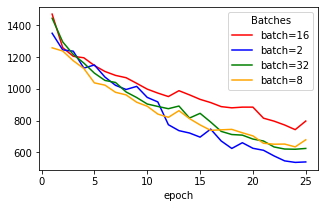

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
df = pd.DataFrame([ ['batch=2', 1, 1350.6712209582329  ], ['batch=2', 2, 1245.930094718933 ], ['batch=2', 3, 1237.6971330046654 ], ['batch=2', 4, 1131.0970337986946 ], ['batch=2', 5, 1150.9151161313057 ], ['batch=2', 6, 1074.6196708083153 ], ['batch=2', 7, 1022.6719473600388 ], ['batch=2', 8, 996.5128929615021 ], ['batch=2', 9, 1016.0202644467354 ],['batch=2', 10, 946.6897876262665 ],['batch=2', 11, 918.1933254599571 ],['batch=2', 12, 774.7046881914139 ],['batch=2', 13, 737.3676149845123 ],['batch=2', 14, 722.4121342301369],['batch=2', 15, 696.5351560115814],['batch=2', 16, 747.0867606401443],['batch=2', 17, 672.1844792366028],['batch=2', 18, 625.3299332261086],['batch=2', 19, 661.2906581759453],['batch=2', 20, 626.2381459474564],['batch=2', 21, 613.6741558909416],['batch=2', 22, 578.123865365982],['batch=2', 23, 546.9938864707947],['batch=2', 24, 537.505654335022],['batch=2', 25, 540.3466841578484]
	
,['batch=8', 1, 1258.8796591758728], ['batch=8', 2, 1238.9171888828278], ['batch=8', 3, 1177.6660174131393], ['batch=8', 4, 1128.7289082407951], ['batch=8', 5, 1038.160305917263], ['batch=8', 6, 1023.8236036896706], ['batch=8', 7, 978.7998277544975], ['batch=8', 8, 962.5593416690826], ['batch=8', 9, 916.3144641518593],['batch=8', 10, 891.0858640670776],['batch=8', 11, 841.7623379826546],['batch=8', 12, 821.1375558972359],['batch=8', 13, 863.0943537354469],['batch=8', 14, 813.1789524555206],['batch=8', 15, 773.4279506802559],['batch=8', 16, 739.3384207487106],['batch=8', 17, 742.5269047617912],['batch=8', 18, 745.4454056024551],['batch=8', 19, 723.8686080574989],['batch=8', 20, 704.3181050419807],['batch=8', 21, 658.0645943284035],['batch=8', 22, 651.949533700943],['batch=8', 23, 652.8892006874084],['batch=8', 24, 635.2115330696106],['batch=8', 25, 679.7234776616096]     
             
,['batch=16', 1, 1470.959224998951], ['batch=16', 2, 1260.0261492729187], ['batch=16', 3, 1205.4019286632538], ['batch=16', 4, 1196.1353618502617], ['batch=16', 5, 1147.2607430815697], ['batch=16', 6, 1109.8521483540535], ['batch=16', 7, 1085.2231158018112], ['batch=16', 8, 1070.6165317893028], ['batch=16', 9, 1035.2684124708176],['batch=16', 10, 998.7360489368439],['batch=16', 11, 973.9176939129829],['batch=16', 12, 952.0016207695007],['batch=16', 13, 988.9084456562996 ],['batch=16', 14, 962.5883077383041],['batch=16', 15, 934.3695965409279],['batch=16', 16, 914.1523735523224],['batch=16', 17, 888.6065450906754],['batch=16', 18, 880.9937360286713],['batch=16', 19, 885.3893580436707],['batch=16', 20, 885.3893580436707],['batch=16', 21, 815.8538061380386],['batch=16', 22, 797.2251756191254],['batch=16', 23, 772.9259285330772],['batch=16', 24, 743.6686852574348],['batch=16', 25, 797.7096936106682]

, ['batch=32', 1, 1445.0366495251656], ['batch=32', 2, 1296.2100131511688], ['batch=32', 3, 1217.0700951814651], ['batch=32', 4, 1162.8013947606087], ['batch=32', 5, 1099.5163615942001], ['batch=32', 6, 1053.4896748661995], ['batch=32', 7, 1040.6337344646454], ['batch=32', 8, 980.9271584749222], ['batch=32', 9, 945.8499310612679],['batch=32', 10, 905.0194133520126],['batch=32', 11, 889.7310754656792],['batch=32', 12, 875.5171407461166],['batch=32', 13, 892.290651679039],['batch=32', 14, 816.6509166955948],['batch=32', 15, 846.3681986927986],['batch=32', 16, 791.5077929496765],['batch=32', 17, 732.6994856595993],['batch=32', 18, 712.9025233387947],['batch=32', 19, 709.1197493076324],['batch=32', 20, 684.3149991631508],['batch=32', 21, 672.1256707310677],['batch=32', 22, 634.6391871571541],['batch=32', 23, 621.6254518032074],['batch=32', 24, 620.239795088768],['batch=32', 25, 625.3300359845161]
       ]      ,      columns= ['Batches', 'epoch', 'loss'])

# pivot the data into the correct shape
df = df.pivot(index='epoch', columns='Batches', values='loss')
df.plot(color=["red","blue","green","orange"], figsize=(5, 3))
